# Pre-proj: check bias time series 
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period_past = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
# seasons = ['Annual', 'DJFMA', 'JJAS']
seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'pr'
table = u.get_table(var)
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
label

'Total Precipitation'

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
APHRODITE V1101 et V1101EX_R1 domain MA: http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/, http://aphrodite.st.hirosaki-u.ac.jp/download/


In [5]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')).sel(time=period_past)

# Resamble data per month (from per day)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period_past.stop) - int(period_past.start) + 1)*12, obs.time.size)

# Compute year mean
temp = [None]*len(seasons)

for k, season in enumerate(seasons):
    # Make year_mean
    temp[k] = u.year_mean(obs, calendar='standard', season=season)
    
obs_ym = xr.concat(temp, pd.Index(seasons, name='season'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [7]:
# (u.spatial_average(obs_ym[0])).plot()

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [8]:
# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder


regridder = xe.Regridder(obs_ym, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_ym_regrid = regridder(obs_ym)
obs_ym_regrid.attrs['long_name'] = label
obs_ym_regrid.attrs['units'] = units

# Compute annual cycle for each zones
temp = [None]*len(zones)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ym_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ym_regrid_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_140x180_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [11]:
# (u.spatial_average(obs_ym_regrid[0])).plot()

## Load models

In [9]:
list_models = u.get_model_names_projections()
# list_models = list_models[:1]
# list_models = ['EC-Earth3']

da_past_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    #################
    ### Load past ###
    #################
    da_past = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
        combine='by_coords').sel(time=period_past, lat=latlim_ext, lon=lonlim_ext)[var]
    
    np.testing.assert_equal((int(period_past.stop) - int(period_past.start) + 1)*12, da_past.time.size)
    
    # pr (mm/s -> mm/day)
    #################################################################################
    
    da_past = da_past * 86400
    
    #################################################################################
    
    for k, season in enumerate(seasons):
        # Make year_mean
        da_past_ym = u.year_mean(da_past, calendar=calendar, season=season)

        # Regrid
        regridder = xe.Regridder(da_past, elevation, 'bilinear', periodic=False, reuse_weights=True)
        da_past_ym_regrid = regridder(da_past_ym)

        # Store result
        da_past_ym_list[k][i] = da_past_ym_regrid.load()
        
    print('\n')

BCC-CSM2-MR (1/12)
Reuse existing file: bilinear_32x54_35x60.nc


CESM2 (2/12)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Reuse existing file: bilinear_37x49_35x60.nc


CNRM-CM6-1 (3/12)
Reuse existing file: bilinear_25x42_35x60.nc


CNRM-CM6-1-HR (4/12)
Reuse existing file: bilinear_70x121_35x60.nc


CNRM-ESM2-1 (5/12)
Reuse existing file: bilinear_25x42_35x60.nc


CanESM5 (6/12)
Reuse existing file: bilinear_13x21_35x60.nc


CanESM5-CanOE (7/12)
Reuse existing file: bilinear_13x21_35x60.nc


IPSL-CM6A-LR (8/12)
Reuse existing file: bilinear_28x25_35x60.nc


MIROC-ES2L (9/12)
Reuse existing file: bilinear_13x21_35x60.nc


MIROC6 (10/12)
Reuse existing file: bilinear_25x42_35x60.nc


MRI-ESM2-0 (11/12)
Reuse existing file: bilinear_32x54_35x60.nc


UKESM1-0-LL (12/12)
Reuse existing file: bilinear_28x32_35x60.nc




In [7]:
# '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest'

In [8]:
# '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/'

## Concatenate results by zones and scenarios

In [10]:
%%time
# Model past
temp = [None]*len(seasons)
for k, season in enumerate(seasons):
    temp[k] = xr.concat(
        da_past_ym_list[k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
    )
mm_past_ym = xr.concat(temp, pd.Index(seasons, name="season"))

temp = [None]*len(zones) 
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        mm_past_ym.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )
mm_past_ym_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

CPU times: user 144 ms, sys: 16 ms, total: 160 ms
Wall time: 158 ms


In [26]:
# mm_past_ym_zones.model
# mm_past_ym_zones

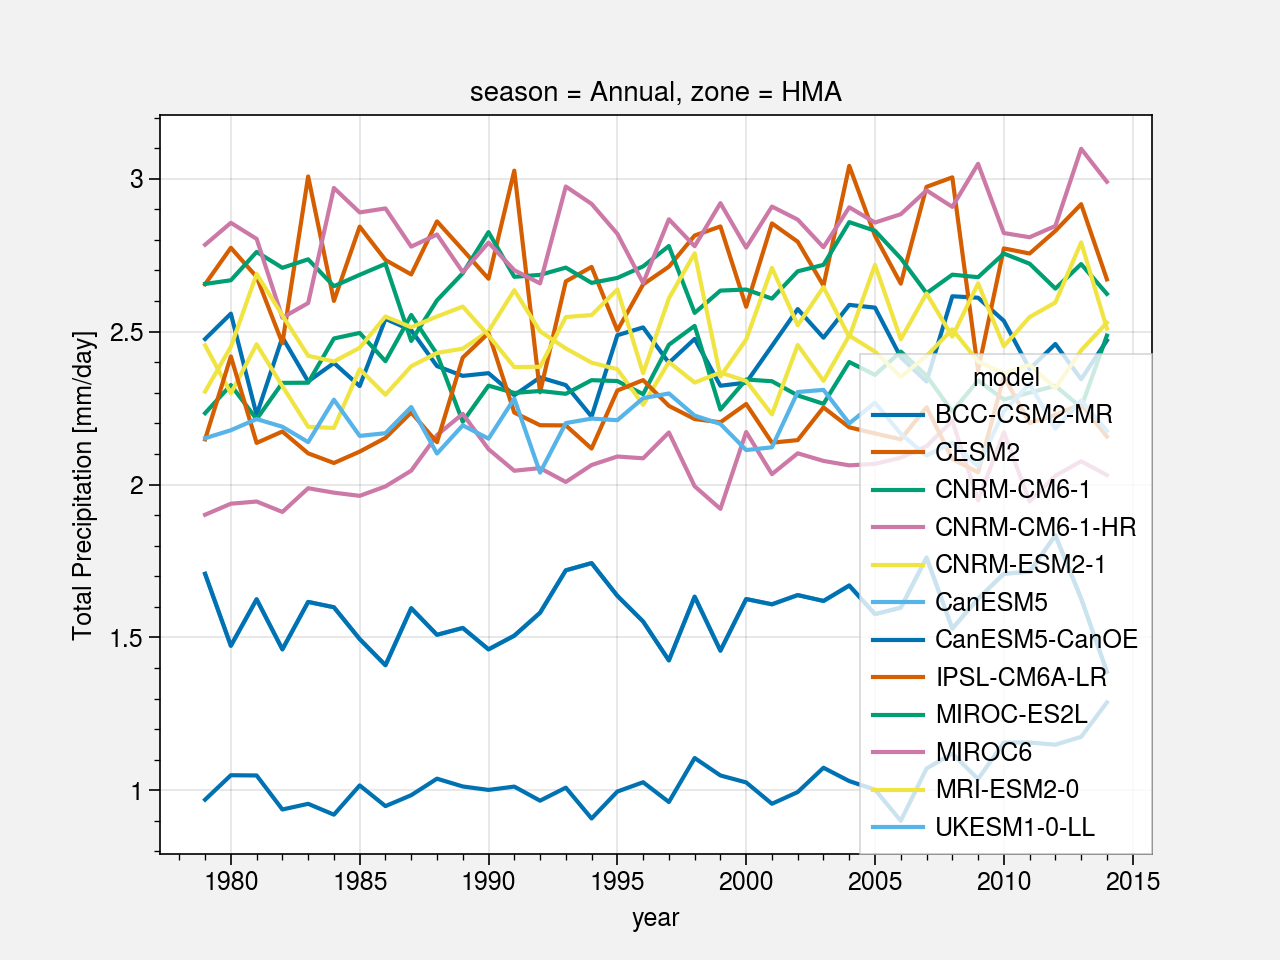

In [11]:
mm_past_ym_zones.sel(season='Annual', zone='HMA').plot(hue='model')
obs_ym_regrid_zones.sel(season='Annual', zone='HMA').plot()

In [11]:
period_past

slice('1979', '2014', None)

## Compute trends

### HMA

In [12]:
indexes = list_models.copy()
indexes.append('Observation')
zone = 'HMA'

df = pd.DataFrame(
    columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'bias'],
    index=indexes
)

for model in list_models:
    
    # Linear regression of the bias
    x = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).year
    y = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).values
    df.loc[model][:5] = stats.linregress(x, y)
    
    # Compute the mean bias
    df.loc[model]['bias'] = (mm_past_ym_zones.sel(season='Annual', zone=zone, model=model).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    

# obs
# Linear regression of the bias
x = obs_ym_regrid_zones.sel(season='Annual', zone=zone).year
y = obs_ym_regrid_zones.sel(season='Annual', zone=zone).values
df.loc['Observation'][:5] = stats.linregress(x, y)

# Compute the mean bias
df.loc['Observation']['bias'] = (obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    
df = df.drop(columns=['intercept', 'rvalue'])
df.slope = df.slope*10 
df.astype(float).round(2)

,slope,pvalue,stderr,bias
BCC-CSM2-MR,0.03,0.11,0.0,1.40
CESM2,0.03,0.33,0.0,1.71
CNRM-CM6-1,-0.00,0.76,0.0,1.32
CNRM-CM6-1-HR,0.03,0.04,0.0,1.02
CNRM-ESM2-1,0.02,0.27,0.0,1.36
CanESM5,0.03,0.07,0.0,0.56
CanESM5-CanOE,0.03,0.07,0.0,0.56
IPSL-CM6A-LR,-0.00,0.86,0.0,1.18
MIROC-ES2L,0.01,0.58,0.0,1.66
MIROC6,0.05,0.00,0.0,1.81


### HK

In [13]:
indexes = list_models.copy()
indexes.append('Observation')
zone = 'HK'

df = pd.DataFrame(
    columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'bias'],
    index=indexes
)

for model in list_models:
    
    # Linear regression of the bias
    x = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).year
    y = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).values
    df.loc[model][:5] = stats.linregress(x, y)
    
    # Compute the mean bias
    df.loc[model]['bias'] = (mm_past_ym_zones.sel(season='Annual', zone=zone, model=model).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    

# obs
# Linear regression of the bias
x = obs_ym_regrid_zones.sel(season='Annual', zone=zone).year
y = obs_ym_regrid_zones.sel(season='Annual', zone=zone).values
df.loc['Observation'][:5] = stats.linregress(x, y)

# Compute the mean bias
df.loc['Observation']['bias'] = (obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    
df = df.drop(columns=['intercept', 'rvalue'])
df.slope = df.slope*10 
df.astype(float).round(2)

,slope,pvalue,stderr,bias
BCC-CSM2-MR,0.01,0.82,0.00,1.52
CESM2,0.06,0.21,0.00,1.41
CNRM-CM6-1,-0.00,0.97,0.00,1.91
CNRM-CM6-1-HR,0.05,0.15,0.00,1.87
CNRM-ESM2-1,0.00,0.99,0.00,1.94
CanESM5,-0.06,0.06,0.00,0.15
CanESM5-CanOE,-0.06,0.06,0.00,0.15
IPSL-CM6A-LR,0.03,0.45,0.00,1.52
MIROC-ES2L,-0.02,0.50,0.00,0.96
MIROC6,0.06,0.07,0.00,1.48


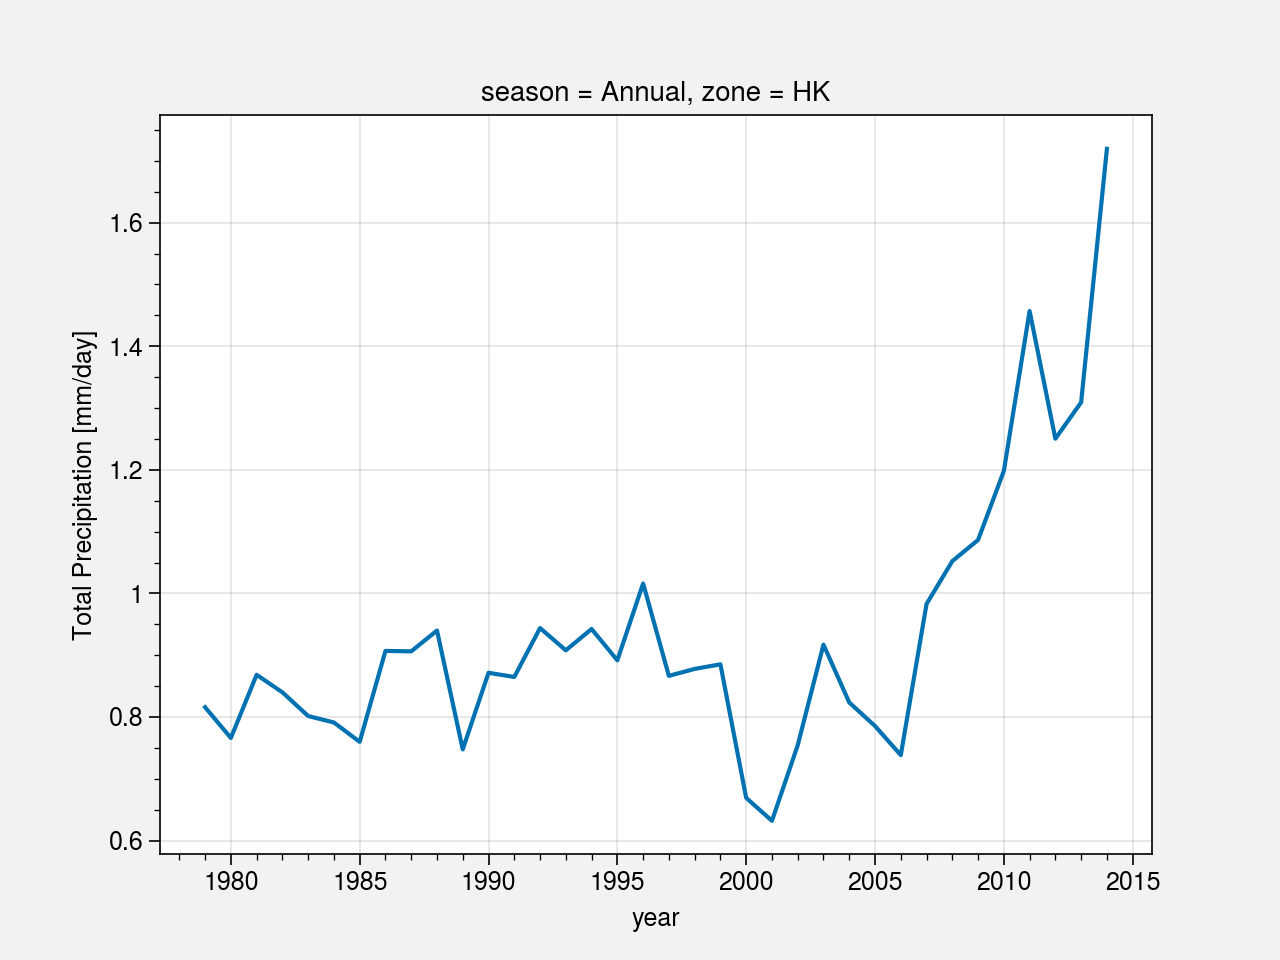

In [14]:
obs_ym_regrid_zones.sel(season='Annual', zone=zone).plot()

### HM

In [15]:
indexes = list_models.copy()
indexes.append('Observation')
zone = 'HM'

df = pd.DataFrame(
    columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'bias'],
    index=indexes
)

for model in list_models:
    
    # Linear regression of the bias
    x = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).year
    y = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).values
    df.loc[model][:5] = stats.linregress(x, y)
    
    # Compute the mean bias
    df.loc[model]['bias'] = (mm_past_ym_zones.sel(season='Annual', zone=zone, model=model).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    

# obs
# Linear regression of the bias
x = obs_ym_regrid_zones.sel(season='Annual', zone=zone).year
y = obs_ym_regrid_zones.sel(season='Annual', zone=zone).values
df.loc['Observation'][:5] = stats.linregress(x, y)

# Compute the mean bias
df.loc['Observation']['bias'] = (obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    
df = df.drop(columns=['intercept', 'rvalue'])
df.slope = df.slope*10 
df.astype(float).round(2)

,slope,pvalue,stderr,bias
BCC-CSM2-MR,0.05,0.40,0.01,2.68
CESM2,0.01,0.90,0.01,3.35
CNRM-CM6-1,-0.03,0.37,0.00,2.16
CNRM-CM6-1-HR,0.07,0.06,0.00,1.82
CNRM-ESM2-1,0.03,0.56,0.00,2.31
CanESM5,0.09,0.06,0.00,0.58
CanESM5-CanOE,0.09,0.06,0.00,0.58
IPSL-CM6A-LR,-0.06,0.32,0.01,2.70
MIROC-ES2L,0.05,0.15,0.00,2.27
MIROC6,0.14,0.01,0.01,4.01


### TP

In [16]:
indexes = list_models.copy()
indexes.append('Observation')
zone = 'TP'

df = pd.DataFrame(
    columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'bias'],
    index=indexes
)

for model in list_models:
    
    # Linear regression of the bias
    x = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).year
    y = mm_past_ym_zones.sel(model=model, season='Annual', zone=zone).values
    df.loc[model][:5] = stats.linregress(x, y)
    
    # Compute the mean bias
    df.loc[model]['bias'] = (mm_past_ym_zones.sel(season='Annual', zone=zone, model=model).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    

# obs
# Linear regression of the bias
x = obs_ym_regrid_zones.sel(season='Annual', zone=zone).year
y = obs_ym_regrid_zones.sel(season='Annual', zone=zone).values
df.loc['Observation'][:5] = stats.linregress(x, y)

# Compute the mean bias
df.loc['Observation']['bias'] = (obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean() - obs_ym_regrid_zones.sel(season='Annual', zone=zone).mean()).values
    
df = df.drop(columns=['intercept', 'rvalue'])
df.slope = df.slope*10 
df.astype(float).round(2)

,slope,pvalue,stderr,bias
BCC-CSM2-MR,0.03,0.04,0.0,1.00
CESM2,0.04,0.11,0.0,1.31
CNRM-CM6-1,0.01,0.63,0.0,0.59
CNRM-CM6-1-HR,0.02,0.19,0.0,0.29
CNRM-ESM2-1,0.04,0.00,0.0,0.63
CanESM5,0.03,0.02,0.0,0.40
CanESM5-CanOE,0.03,0.02,0.0,0.40
IPSL-CM6A-LR,-0.01,0.61,0.0,0.52
MIROC-ES2L,0.01,0.38,0.0,1.66
MIROC6,0.02,0.11,0.0,1.18


## Check CanESM5

In [10]:
path = '/bdd/CMIP6/CMIP/CCCma/CanESM5/historical/r*i1p1f1/Amon/tas/gn/latest/tas_Amon_CanESM5_historical_r*i1p1f1_gn_185001-201412.nc'

ds = xr.open_mfdataset(path, combine='nested', concat_dim='realization').sel(time=period_past, lat=latlim_ext, lon=lonlim_ext).tas
ds

<xarray.DataArray 'tas' (realization: 25, time: 432, lat: 13, lon: 21)>
dask.array<getitem, shape=(25, 432, 13, 21), dtype=float32, chunksize=(1, 432, 13, 21), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 56.25 59.06 61.88 64.69 ... 104.1 106.9 109.7 112.5
  * lat      (lat) float64 15.35 18.14 20.93 23.72 ... 40.46 43.25 46.04 48.84
  * time     (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: realization
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    units:          K
    original_name:  ST
    history:        degctok 2019-04-30T17:40:12Z altered by CMOR: Treated sca...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

In [11]:
# tas (K -> °C)
#################################################################################

ds -= 273.15

#################################################################################

# Make year_mean
ds_ym = u.year_mean(ds)

# Regrid
regridder = xe.Regridder(ds_ym, elevation, 'bilinear', periodic=False, reuse_weights=True)
ds_ym_regrid = regridder(ds_ym)

Reuse existing file: bilinear_13x21_35x60.nc


In [12]:
ds_ave_tas = u.spatial_average(ds_ym_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
ds_ave_tas

<xarray.DataArray (realization: 25, year: 36)>
dask.array<sum-aggregate, shape=(25, 36), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2010 2011 2012 2013 2014
Dimensions without coordinates: realization
Attributes:
    regrid_method:  bilinear

## Check snc

In [14]:
path = '/bdd/CMIP6/CMIP/CCCma/CanESM5/historical/r*i1p1f1/LImon/snc/gn/latest/snc_LImon_CanESM5_historical_r*i1p1f1_gn_185001-201412.nc'

ds = xr.open_mfdataset(path, combine='nested', concat_dim='realization').sel(time=period_past, lat=latlim_ext, lon=lonlim_ext).snc
ds

<xarray.DataArray 'snc' (realization: 25, time: 432, lat: 13, lon: 21)>
dask.array<getitem, shape=(25, 432, 13, 21), dtype=float32, chunksize=(1, 432, 13, 21), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 56.25 59.06 61.88 64.69 ... 104.1 106.9 109.7 112.5
  * lat      (lat) float64 15.35 18.14 20.93 23.72 ... 40.46 43.25 46.04 48.84
  * time     (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: realization
Attributes:
    standard_name:  surface_snow_area_fraction
    long_name:      Snow Area Percentage
    comment:        FNT(1)*FARE(1), CMIP_table_comment: Fraction of each grid...
    units:          %
    original_name:  FN
    history:        mltby100 2019-04-30T23:05:07Z altered by CMOR: Reordered ...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

In [15]:
# Make year_mean
ds_ym = u.year_mean(ds)

# Regrid
regridder = xe.Regridder(ds_ym, elevation, 'bilinear', periodic=False, reuse_weights=True)
ds_ym_regrid = regridder(ds_ym)

Reuse existing file: bilinear_13x21_35x60.nc


In [16]:
ds_ave_snc = u.spatial_average(ds_ym_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
ds_ave_snc

<xarray.DataArray (realization: 25, year: 36)>
dask.array<sum-aggregate, shape=(25, 36), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2010 2011 2012 2013 2014
Dimensions without coordinates: realization
Attributes:
    regrid_method:  bilinear

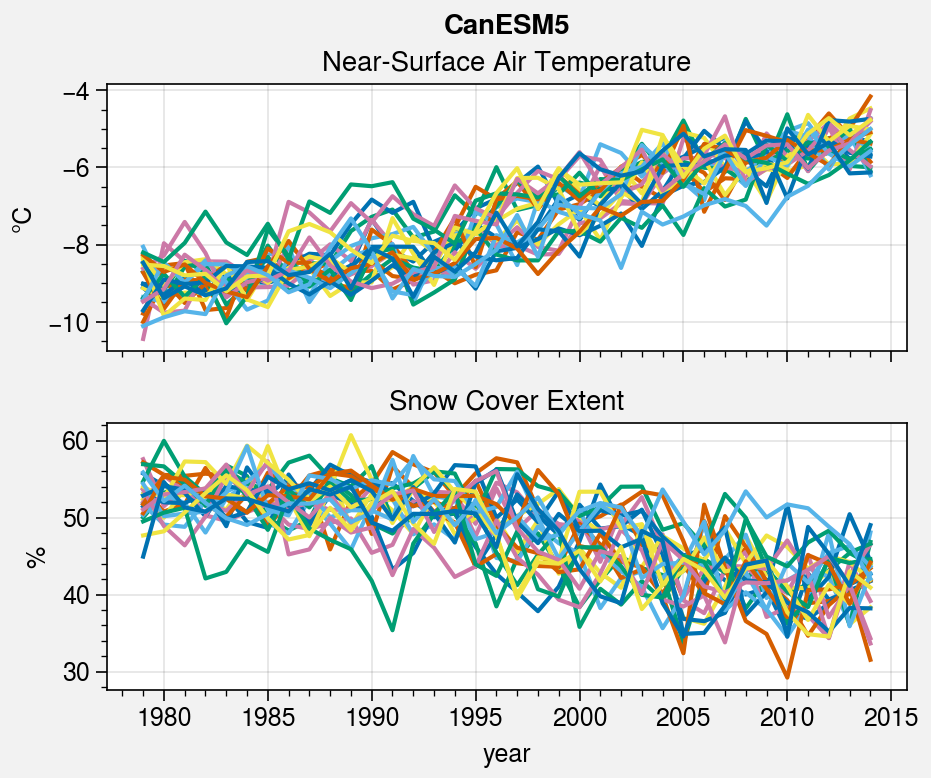

In [61]:
f, axs = plot.subplots(ncols=1, nrows=2, sharey=0, aspect=3, axwidth=4)

for i in range(ds_ave_tas.realization.size):
# for i in range(1):
    axs[0].plot(ds_ave_tas.isel(realization=i))
    axs[1].plot(ds_ave_snc.isel(realization=i))

axs[0].format(title='Near-Surface Air Temperature')
axs[1].format(title='Snow Cover Extent')

axs[0].format(ylabel='°C')
axs[1].format(ylabel='%')

axs.format(
    suptitle='CanESM5'
)

f.save('img/CanESM5_timeseries_snc_tas_ensemble.jpg')

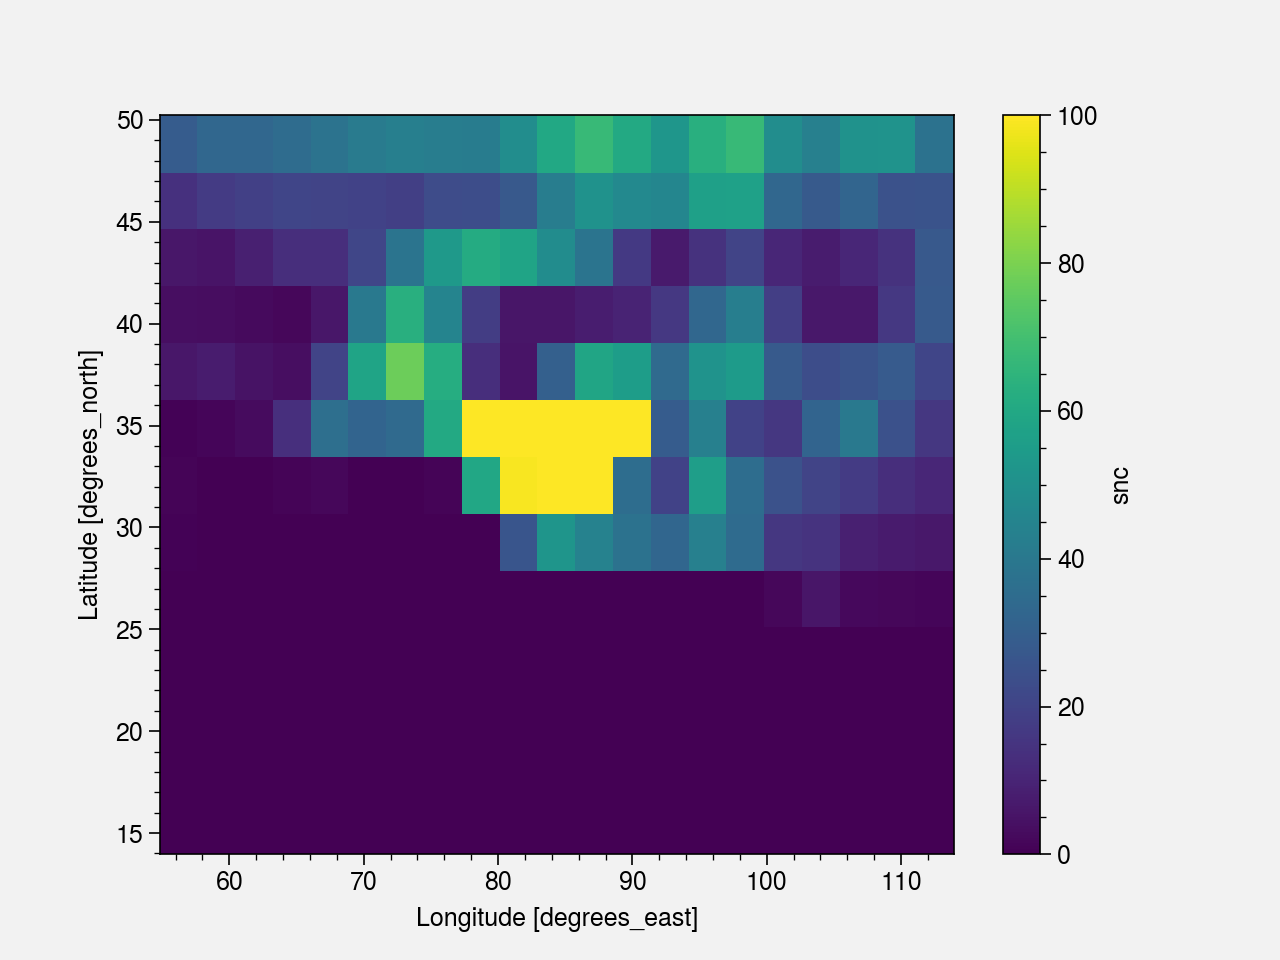

In [86]:
ds[0].sel(time=slice('1979','1990')).mean('time').plot()

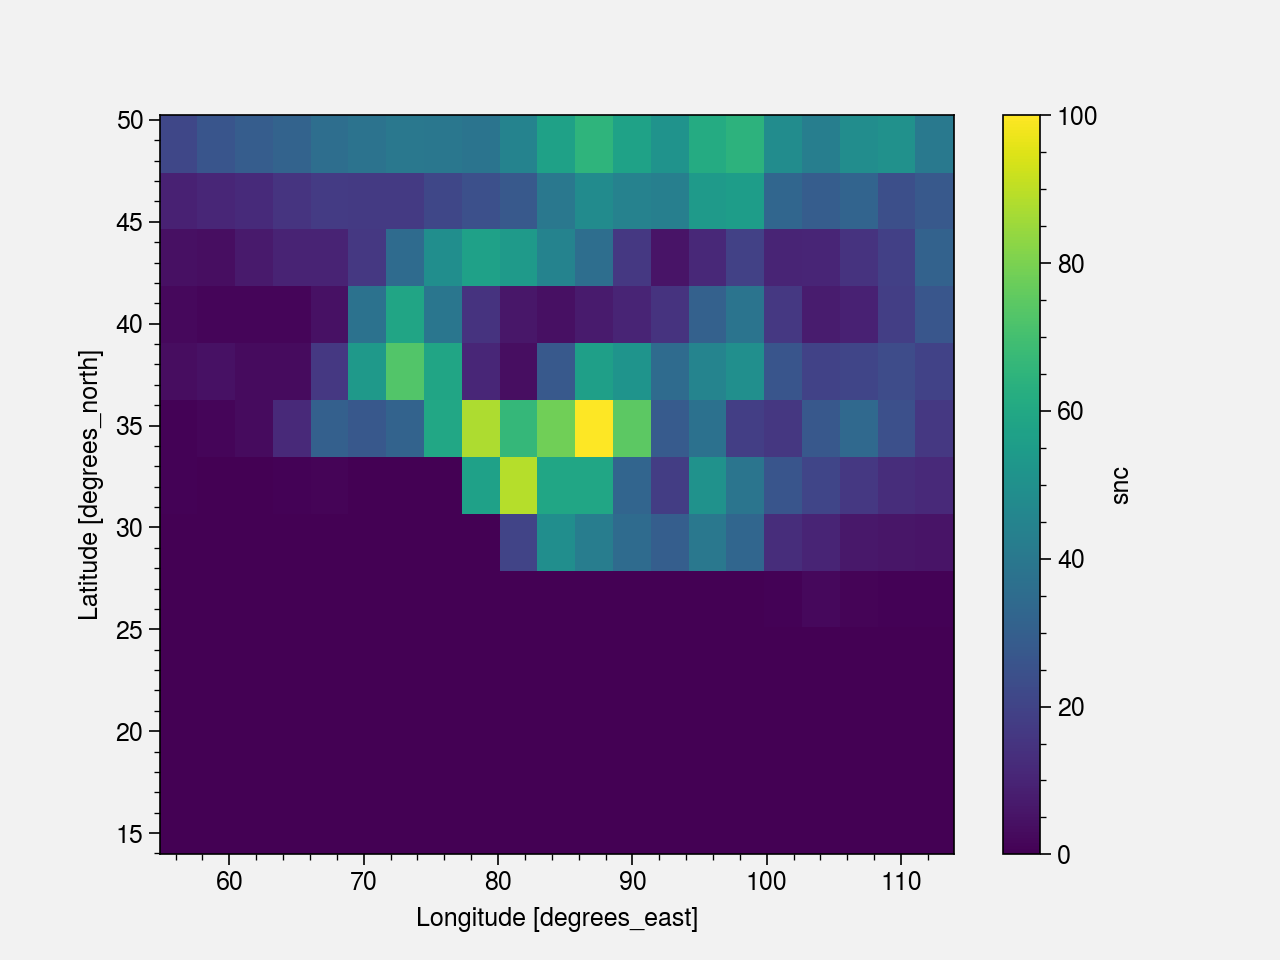

In [87]:
ds[0].sel(time=slice('1990','2014')).mean('time').plot()

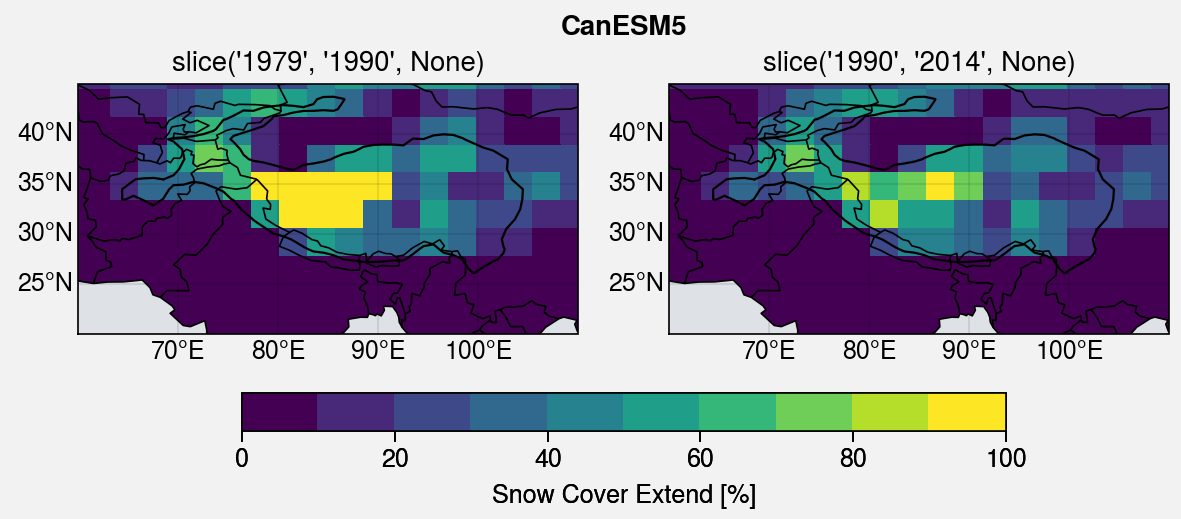

In [99]:
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=1)

for i, period in enumerate([slice('1979','1990'), slice('1990','2014')]):
    # Add contour 2500 m
    axs[i].contour(elevation, levels=[2500], color='black', linewidth=0.8)

    norm = plot.Norm('diverging', fair=False)
    
    # Plot observation
    m = axs[i].pcolormesh(
        ds[0].sel(time=period).mean('time'), cmap='viridis', 
        levels=plot.arange(0,100,10), 
        extend='neither'
    )
    axs[i].format(title=period)


f.colorbar(m, label = 'Snow Cover Extend [%]', loc='b', length=0.7)

axs.format(
    # Grids, labels and limits
    labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),

    # Add coast, ocean, borders
    coast=True, ocean=True, oceancolor='gray3', borders=True,

    # Suptitle
    suptitle='CanESM5' 
)

filename = 'CanESM5_snc'
f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

## Load future
To check if CanESM stays higher than others (climate sensitivity too big) or if it starts to stabialize, what could suggest a strong answer to snow melt around 1990.

['BCC-CSM2-MR',
 'CESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [24]:
period_future = slice('2015','2100')
scenario = 'ssp585'

list_models = u.get_model_names_projections()
list_models.remove('CESM2')
# list_models = list_models[:1]
# list_models = ['EC-Earth3']

da_future_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    #################
    ### Load ssp585 ###
    #################
    if model in ['IPSL-CM6A-LR', 'MRI-ESM2-0']:
        da_future = xr.open_mfdataset(
            '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*210012.nc', 
            combine='by_coords').sel(time=period_future, lat=latlim_ext, lon=lonlim_ext)[var]
    else:
        da_future = xr.open_mfdataset(
            '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
            combine='by_coords').sel(time=period_future, lat=latlim_ext, lon=lonlim_ext)[var]
    
    np.testing.assert_equal((int(period_future.stop) - int(period_future.start) + 1)*12, da_future.time.size)
    
    # tas (K -> °C)
    #################################################################################

    da_future -= 273.15
        
    #################################################################################
    
    for k, season in enumerate(seasons):
        # Make year_mean
        da_future_ym = u.year_mean(da_future, calendar=calendar, season=season)

        # Regrid
        regridder = xe.Regridder(da_future, elevation, 'bilinear', periodic=False, reuse_weights=True)
        da_future_ym_regrid = regridder(da_future_ym)

        # Store result
        da_future_ym_list[k][i] = da_future_ym_regrid.load()
        
    print('\n')

BCC-CSM2-MR (1/11)
Reuse existing file: bilinear_32x54_35x60.nc


CNRM-CM6-1 (2/11)
Reuse existing file: bilinear_25x42_35x60.nc


CNRM-CM6-1-HR (3/11)
Reuse existing file: bilinear_70x121_35x60.nc


CNRM-ESM2-1 (4/11)
Reuse existing file: bilinear_25x42_35x60.nc


CanESM5 (5/11)
Reuse existing file: bilinear_13x21_35x60.nc


CanESM5-CanOE (6/11)
Reuse existing file: bilinear_13x21_35x60.nc


IPSL-CM6A-LR (7/11)
Reuse existing file: bilinear_28x25_35x60.nc


MIROC-ES2L (8/11)
Reuse existing file: bilinear_13x21_35x60.nc


MIROC6 (9/11)
Reuse existing file: bilinear_25x42_35x60.nc


MRI-ESM2-0 (10/11)
Reuse existing file: bilinear_32x54_35x60.nc


UKESM1-0-LL (11/11)
Reuse existing file: bilinear_28x32_35x60.nc




In [25]:
# '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc'

In [26]:
%%time
# Model past
temp = [None]*len(seasons)
for k, season in enumerate(seasons):
    temp[k] = xr.concat(
        da_future_ym_list[k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
    )
mm_future_ym = xr.concat(temp, pd.Index(seasons, name="season"))

temp = [None]*len(zones) 
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        mm_future_ym.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )
mm_future_ym_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

CPU times: user 201 ms, sys: 48 ms, total: 249 ms
Wall time: 1.21 s


In [29]:
mm_past_ym_zones.sel(zone='HMA', season='Annual')

<xarray.DataArray (model: 12, year: 36)>
array([[-2.52951707e+00, -3.05038303e+00, -2.86468320e+00,
        -2.66664528e+00, -3.11446679e+00, -3.37815424e+00,
        -3.41227052e+00, -3.36102210e+00, -4.05007885e+00,
        -3.66481104e+00, -3.03100202e+00, -2.30370862e+00,
        -2.60356502e+00, -3.38757135e+00, -2.96624660e+00,
        -3.18329726e+00, -2.19855565e+00, -3.32822648e+00,
        -2.79033276e+00, -2.81453837e+00, -2.94022357e+00,
        -2.07000780e+00, -2.31486408e+00, -2.62470975e+00,
        -2.38807669e+00, -2.77767731e+00, -2.60654882e+00,
        -2.60845042e+00, -2.45386126e+00, -2.41448458e+00,
        -2.41657225e+00, -2.20241164e+00, -1.81297355e+00,
        -2.68161039e+00, -1.78485733e+00, -2.25956427e+00],
       [-1.60329929e-01, -3.65083901e-01, -3.41176544e-03,
        -5.93573968e-01, -6.45140481e-01,  1.94721644e-01,
        -2.31185755e-01, -2.10774298e-01, -4.15725627e-02,
         1.67170117e-01,  6.79610375e-02,  7.42709231e-02,
         3.31127775e-01, -6.87673405e-01, -3.64824377e-01,
         5.67196724e-01,  2.20133804e-01,  4.32817947e-01,
        -1.53461373e-01,  8.37636169e-02,  1.50044541e+00,
         4.63942543e-01,  8.15383560e-01,  6.63700312e-01,
...
        -2.83657938e+00, -3.47179063e+00, -3.54713004e+00,
        -3.11163017e+00, -3.37897054e+00, -2.75870164e+00,
        -3.11961500e+00, -3.84376906e+00, -2.88549654e+00,
        -3.05803468e+00, -2.50741895e+00, -2.51429451e+00,
        -2.70609699e+00, -3.55636667e+00, -3.00973341e+00,
        -3.56099049e+00, -2.51390449e+00, -2.96791230e+00,
        -3.78997974e+00, -2.44392120e+00, -2.72444969e+00,
        -2.82694185e+00, -2.86288502e+00, -2.74022912e+00],
       [-1.39709320e+00, -1.77790696e+00, -1.53155672e+00,
        -1.56900275e+00, -1.90395534e+00, -1.66199155e+00,
        -1.15478605e+00, -1.78039688e+00, -1.15683932e+00,
        -1.66722576e+00, -1.17425244e+00, -1.21758892e+00,
        -1.87249421e+00, -1.92623193e+00, -1.70113028e+00,
        -1.39311894e+00, -1.14373359e+00, -1.29924178e+00,
        -1.30854428e+00, -1.33850423e+00, -8.12301188e-01,
        -8.87582472e-01, -9.11719565e-01, -6.37909393e-01,
        -6.52599981e-01, -1.35772137e+00, -9.08536071e-01,
        -3.33666306e-01, -9.53216561e-01, -9.43576510e-01,
        -3.17208864e-01, -4.81119126e-01, -6.40410389e-01,
        -4.46175467e-01, -3.18330780e-01, -4.03336192e-01]])
Coordinates:
    height   float64 2.0
  * model    (model) object 'BCC-CSM2-MR' 'CESM2' ... 'MRI-ESM2-0' 'UKESM1-0-LL'
    season   <U6 'Annual'
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2010 2011 2012 2013 2014
    zone     <U3 'HMA'
Attributes:
    regrid_method:  bilinear

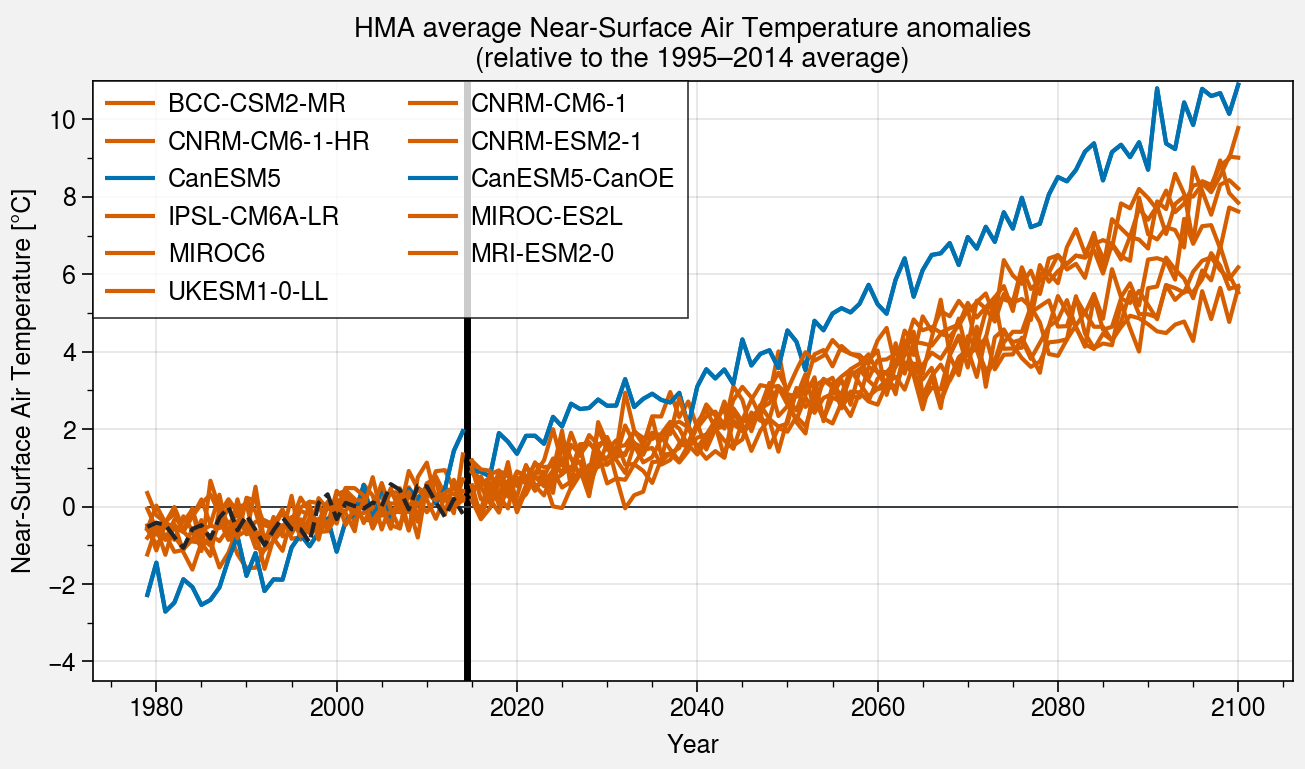

In [53]:
fig, ax = plot.subplots(aspect=2, axwidth=6)

zone = 'HMA'
ymin = -4.5
ymax = 11

#################################
### Compute the climatologies ###
#################################
clim_model = mm_past_ym_zones.sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean()
clim_obs = obs_ym_regrid_zones.sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean()


###################
### Models past ###
###################
h_past = []
for i, model in enumerate(mm_future_ym_zones.model.values):
    
    if model in ['CanESM5', 'CanESM5-CanOE']:
        color='C0' 
    else:
        color='C1'

    clim = mm_past_ym_zones.sel(zone='HMA', season='Annual', model=model, year=slice('1995','2014')).mean()
    anomalies = mm_past_ym_zones.sel(zone='HMA', season='Annual', model=model) - clim
    
    h = ax.plot(anomalies, label=model, color=color)
    h_past.append(h)


    #####################
    ### Models future ###
    #####################
    colors = ['indigo9', 'blue5', 'orange5', 'red6']
    scenarios = ['ssp585']
    h_future = [None]*len(scenarios)

    for i, scenario in enumerate(scenarios):

        clim = mm_past_ym_zones.sel(zone='HMA', season='Annual', model=model, year=slice('1995','2014')).mean()
        anomalies = mm_future_ym_zones.sel(zone='HMA', season='Annual', model=model) - clim

        h_future[i] = ax.plot(anomalies, label=model, color=color)
        
###########
### Obs ###
###########
h_obs = ax.plot(
    (obs_ym_regrid_zones.sel(zone=zone, season=seasons[0]) - clim_obs), 
    label=obs_name, color='gray9', linestyle='--'
)


#############
### Lines ###
#############
ax.vlines(2014.5, ymin, ymax, linewidth=2.5)
ax.hlines(0, 1979, 2100, linewidth=0.7, color='gray8')


#######################
### Legend / Format ###
#######################
ax.legend(h_past, loc='ul', frame=True, ncols=2)

ax.format(
    title='HMA average '+label+' anomalies\n(relative to the 1995–2014 average)', 
    ylabel=label + ' ['+units+']', ylocator=2, yminorlocator=1.00001, ylim=(ymin,ymax),
    xlabel='Year', xminorlocator=5, xlocator=20
)

fig.save('img/CanESM5_tas_projections_ssp585.jpg')

In [12]:
list_models = u.get_model_names_projections()

In [13]:
list_models_2 = list_models
list_models_2

['BCC-CSM2-MR',
 'CESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [14]:
list_models_2.remove('CanESM5')
list_models_2.remove('CanESM5-CanOE')

In [15]:
list_models_2

['BCC-CSM2-MR',
 'CESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [16]:
x = bias.year
y = bias.mean('model').values
stats.linregress(x, y)

NameError: name 'bias' is not defined

In [ ]:
x = bias.year
y = bias.sel(model=list_models_2).mean('model').values
stats.linregress(x, y)